## Stock Price Prediction of Google

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Reading data

In [2]:
dataset = pd.read_csv('GOOG.csv', parse_dates=True, index_col='Date', infer_datetime_format=True)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


## EDA

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3943 entries, 2004-08-19 to 2020-04-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3943 non-null   float64
 1   High       3943 non-null   float64
 2   Low        3943 non-null   float64
 3   Close      3943 non-null   float64
 4   Adj Close  3943 non-null   float64
 5   Volume     3943 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 215.6 KB


In [4]:
dataset.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [5]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3.943000e+03
mean,505.452652,510.123793,500.582603,505.498065,505.498065,6.999099e+06
std,354.729456,357.834801,351.839186,355.069271,355.069271,8.030610e+06
min,49.409801,50.680038,47.800831,49.818268,49.818268,7.900000e+03
25%,238.842254,240.814865,235.813614,237.666664,237.666664,1.758550e+06
50%,328.852386,333.211029,324.399078,329.026733,329.026733,4.298500e+06
75%,740.914978,745.225006,736.024994,740.970001,740.970001,8.931050e+06
max,1525.069946,1532.105957,1521.400024,1526.689941,1526.689941,8.254150e+07


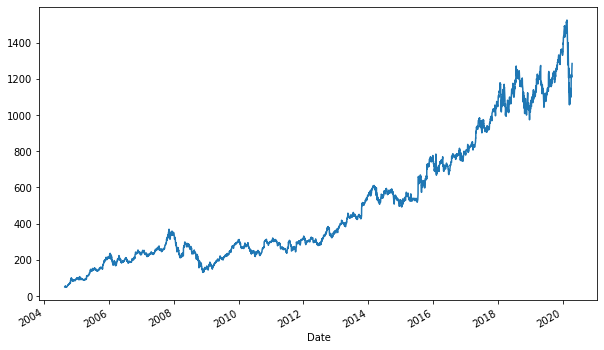

In [6]:
dataset['Open'].plot(figsize=(10,6))

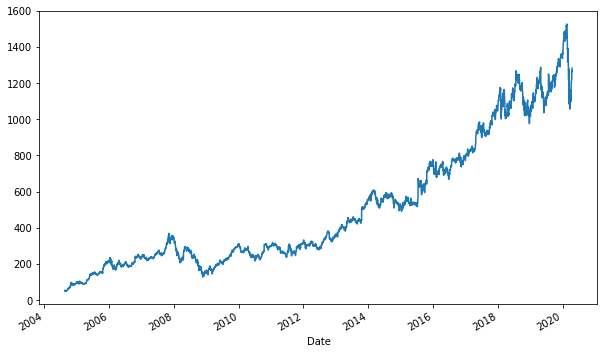

In [7]:
dataset['Adj Close'].plot(figsize=(10,6))

## Preprocessing: Train test Split 

In [8]:
train = dataset[dataset.index < '2019-01-01'].copy()
test = dataset[dataset.index >= '2019-01-01'].copy()

In [9]:
train = train.drop(['Adj Close'], axis=1)
test = test.drop(['Adj Close'], axis=1)

In [10]:
test = train.tail(60).append(test)

## Normalizing the data

In [11]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

## Converting a big sequence into smaller ones

In [12]:
def create_sequences(data, seq_length):
    X, y = [], []

    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, 0])

    return np.array(X), np.array(y)

In [13]:
seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

## Building LSTM Model

In [14]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=92),input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(rate=0.2))
regressor.add(Dense(units=1))
regressor.compile(loss='mean_squared_error', optimizer='adam')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 184)               72128     
_________________________________________________________________
dropout (Dropout)            (None, 184)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 185       
Total params: 72,313
Trainable params: 72,313
Non-trainable params: 0
_________________________________________________________________


## Training

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [16]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [17]:
history = regressor.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    shuffle=False
)

Epoch 1/100
100/100 [==============================] - 4s 45ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 2/100
100/100 [==============================] - 4s 35ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/100
100/100 [==============================] - 4s 38ms/step - loss: 5.6081e-04 - val_loss: 0.0013
Epoch 4/100
100/100 [==============================] - 4s 37ms/step - loss: 5.6124e-04 - val_loss: 0.0013
Epoch 5/100
100/100 [==============================] - 4s 38ms/step - loss: 4.8773e-04 - val_loss: 0.0011
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 5.6576e-04 - val_loss: 0.0016
Epoch 7/100
100/100 [==============================] - 4s 44ms/step - loss: 5.2090e-04 - val_loss: 0.0023
Epoch 8/100
100/100 [==============================] - 4s 40ms/step - loss: 6.0503e-04 - val_loss: 0.0018
Epoch 9/100
100/100 [==============================] - 5s 46ms/step - loss: 5.2328e-04 - val_loss: 0.0015
Epoch 10/100
100/100 [==============================] 

100/100 [==============================] - 5s 48ms/step - loss: 2.8724e-04 - val_loss: 2.7478e-04
Epoch 76/100
100/100 [==============================] - 5s 52ms/step - loss: 1.7298e-04 - val_loss: 3.5086e-04
Epoch 77/100
100/100 [==============================] - 6s 64ms/step - loss: 1.5997e-04 - val_loss: 5.0637e-04
Epoch 78/100
100/100 [==============================] - 7s 66ms/step - loss: 1.7936e-04 - val_loss: 1.7026e-04
Epoch 79/100
100/100 [==============================] - 8s 82ms/step - loss: 1.6406e-04 - val_loss: 1.8749e-04
Epoch 80/100
100/100 [==============================] - 5s 52ms/step - loss: 1.2710e-04 - val_loss: 2.8109e-04
Epoch 81/100
100/100 [==============================] - 8s 78ms/step - loss: 1.5482e-04 - val_loss: 4.9028e-04
Epoch 82/100
100/100 [==============================] - 6s 60ms/step - loss: 1.9635e-04 - val_loss: 2.5023e-04
Epoch 83/100
100/100 [==============================] - 7s 67ms/step - loss: 1.6994e-04 - val_loss: 2.7761e-04
Epoch 84/100
1

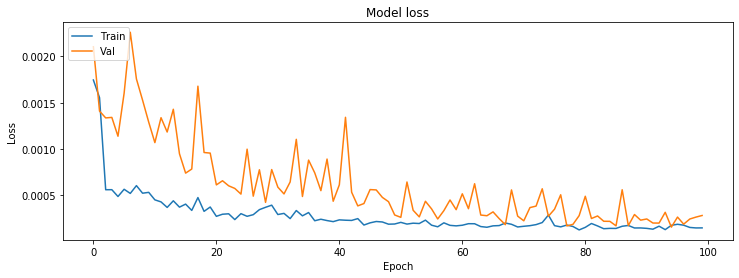

In [18]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Prediction

In [19]:
y_pred = regressor.predict(X_test)

In [20]:
scale = 1/scaler.scale_[0]

In [21]:
y_pred = y_pred*scale
y_test = y_test*scale

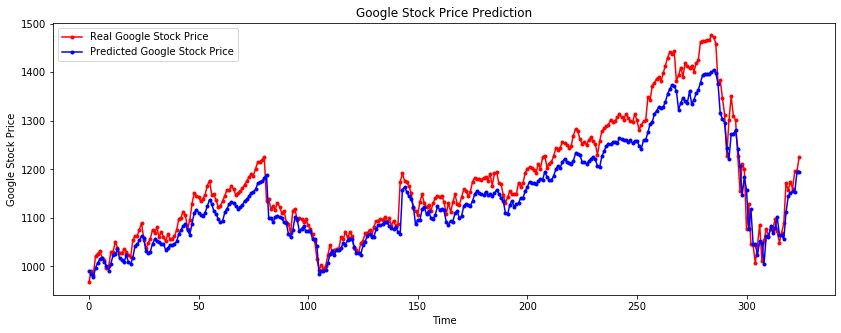

In [22]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', marker='.', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', marker='.', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## Converting & Saving Prediction data

In [23]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred, columns=['Prediction'])
results = pd.concat([col1, col2], axis=1)
results.to_excel('Results_LSTM.xlsx')